<a href="https://colab.research.google.com/github/VindhyaSRajan/Guided-Research/blob/LSTM/LDA_RecipeTitles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#Imports and Installations

In [0]:
!pip install gensim
!pip install warnings
!pip install pyLDAvis

In [39]:
import pandas as pd
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

#Used Gensim implementation of the LDA model
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases
from numpy import array
import nltk
nltk.download('wordnet')
import matplotlib.pyplot as plt

#Useful for Tokenisation and Lemmatisation
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Loading the raw data

In [4]:
df_recipe = pd.read_csv('/content/drive/My Drive/Dataa/recipe_title_foodCategory_v3.csv', error_bad_lines= False)
df_recipe.shape

(47668, 3)

In [5]:
df_recipe.head()

,Unnamed: 0,Recipe_Title,Food_Category
0,14164,Hummus Pasta,Hummus
1,22552,Endive-and-Arugula Salad with Chile-Garlic Dre...,Salad
2,2346,Apple Crumb Cake Recipe,Cake
3,44716,Hamburger Lentil Potato Tomato Stew,Stew
4,27168,"Healthy Oat Bran Muffins with Banana, Blueberr...",Muffins


##Pre-processing the Recipe Titles

In [58]:
# Convert to array
documents =array(df_recipe['Recipe_Title'].astype(str))
print(type(documents))
print(len(documents))

<class 'numpy.ndarray'>
47668


In [0]:
# Define function for tokenize and lemmatizing

def preprocess_docs(documents):
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(documents)):
        documents[i] = documents[i].lower()  # All words to be in lowercase.
        documents[i] = tokenizer.tokenize(documents[i])  # Tokenisation.

    # Remove every token which is a number.
    documents = [[token for token in doc if not token.isdigit()] for doc in documents]
    
    # Remove tokens that are single charactered.
    documents = [[token for token in doc if len(token) > 3] for doc in documents]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    documents = [[lemmatizer.lemmatize(token) for token in doc] for doc in documents]
  
    return documents

In [0]:
# Perform function on our recipe titles aka documents
documents = preprocess_docs(documents)

In [0]:
#For Biagram & Trigram Models 
bigram = Phrases(documents, min_count=10)
trigram = Phrases(bigram[documents])

In [0]:
for i in range(len(documents)):
    for token in bigram[documents[i]]:
        if '_' in token:
            # if token is a bigram, we'll add to the document list.
            documents[i].append(token)
    for token in trigram[documents[i]]:
        if '_' in token:
            # Similarly for tri-gram.
            documents[i].append(token)


In [47]:
#We do not want rare tokens, so removing it 
# Converting all the recipe titles aka document to dictionary
dictionary = Dictionary(documents)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('Unique token in our corpus: %d' % len(dictionary))
print('Unique Docs in the corpus: %d' % len(corpus))
print(corpus[:1])

Unique token in our corpus: 1693
Unique Docs in the corpus: 47668
[[(0, 1), (1, 1)]]


In [48]:
type(corpus)

list

##LDA on the Recipe Title of the Recipe 1M data

In [49]:
# Set parameters.
num_topics = 30
chunksize = 500 
passes = 20 
iterations = 500
eval_every = 1  

# idx 2 word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

#Calling the gensim LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(28, '0.160*"pepper" + 0.132*"roasted_pepper" + 0.059*"stir" + 0.058*"roasted" + 0.058*"stir_fried" + 0.041*"white_wine" + 0.031*"beet" + 0.030*"mozzarella" + 0.029*"heirloom_tomato" + 0.023*"arugula"'), (11, '0.123*"bacon" + 0.117*"blue_cheese" + 0.072*"bacon_wrapped" + 0.065*"avocado" + 0.061*"salsa" + 0.051*"wrapped" + 0.048*"blue" + 0.047*"cilantro" + 0.047*"cheese" + 0.023*"crunchy"'), (9, '0.101*"dried_tomato" + 0.071*"basil" + 0.064*"olive" + 0.053*"yogurt" + 0.052*"crispy" + 0.051*"dried" + 0.042*"tomato" + 0.035*"healthy" + 0.034*"dough" + 0.033*"raisin"'), (16, '0.105*"white" + 0.102*"turkey" + 0.095*"white_bean" + 0.066*"simple" + 0.061*"upside_down" + 0.057*"best" + 0.035*"down" + 0.035*"upside" + 0.030*"bean" + 0.030*"marinade"'), (24, '0.173*"slow_cooker" + 0.075*"chocolate_chip" + 0.065*"slow" + 0.064*"mexican" + 0.063*"cooker" + 0.061*"chip" + 0.043*"warm" + 0.040*"french" + 0.039*"breakfast" + 0.035*"spiced"'), (22, '0.086*"roll" + 0.082*"fruit" + 0.071*"spring_roll" 

In [50]:
#This code block is to see as a data frame what each topic actually comprises of.
word_dictionary = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 10)
    word_dictionary['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dictionary)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20,Topic # 21,Topic # 22,Topic # 23,Topic # 24,Topic # 25,Topic # 26,Topic # 27,Topic # 28,Topic # 29,Topic # 30
0,garlic,cream,cake,casserole,recipe,smoothie,chili,green,with,dried_tomato,pizza,bacon,cheese,taco,salad,pumpkin,white,muffin,soup,lemon,tomato,bread,roll,rice,slow_cooker,potato,apple,burger,pepper,pasta
1,pork,black_bean,chocolate,broccoli,style,cherry,spicy,bean,sauce,basil,steak,blue_cheese,coconut,whole_wheat,spinach,orange,turkey,fried,beef,salmon,easy,pudding,fruit,wild_rice,chocolate_chip,sweet_potato,pancake,onion,roasted_pepper,creamy
2,poppy_seed,sour_cream,coffee_cake,breast,mustard,strawberry,corn,green_bean,vegetable,olive,sandwich,bacon_wrapped,cream,zucchini,dressing,carrot,white_bean,gluten_free,stew,honey,noodle,banana,spring_roll,quick,slow,sweet,shrimp,goat_cheese,stir,smoked_salmon
3,fresh,pound_cake,barbecue,roast,honey_mustard,crock,ginger,italian,pecan,yogurt,grilled,avocado,buttermilk,squash,cucumber,cranberry,simple,blueberry,baked,asian,mushroom,peanut_butter,crab,tuna,mexican,roasted,wrap,parmesan,roasted,sausage
4,herb,black,homemade,glazed,guacamole,lime,pineapple,cabbage,spaghetti,crispy,cocktail,salsa,pastry,wheat,beef_tenderloin,walnut,upside_down,free,stuffed,hummus,cheesy,butter,mango,curry,cooker,french_onion,greek,turkey_burger,stir_fried,smoked
5,pork_chop,bean,coffee,sesame,layer,maple,mini,mixed_green,caramel,dried,pear,wrapped,cheddar,summer,wine,spread,best,bran_muffin,skillet,pickled,bake,peanut,quinoa,custard,chip,pickle,lettuce_wrap,brown,white_wine,almond
6,dill,sour,peach,wing,horseradish,pie,spice,prosciutto,bundt_cake,tomato,veggie,blue,puff_pastry,dairy_free,asparagus,lentil,down,berry,family_favorite,apricot,wild,bread_machine,vegetarian,bell_pepper,warm,dill,cinnamon,cheese,beet,salmon
7,from,pound,angel_hair,cauliflower,good,chipotle,dipping,cajun,fish,healthy,flank_steak,cilantro,chile,butternut_squash,thai,tortilla,upside,gluten,favorite,german,teriyaki,sweet_sour,spring,fennel,french,dill_pickle,vegan,goat,mozzarella,mediterranean
8,seed,crust,ground_beef,leek,deep_dish,beer,dipping_sauce,seared,vanilla,dough,marinated,cheese,fudge,whole,curried,artichoke,bean,minute,oven,meat,classic,pesto,stuffing,seafood,breakfast,tart,oatmeal,alfredo,heirloom_tomato,chop
9,ricotta,scone,delicious,eggplant,dish,dumpling,topping,oamc,crusted,raisin,buffalo,crunchy,american,super,vinaigrette,bowl,marinade,sugar_free,barley,brown_sugar,penne,lamb,balsamic,light,spiced,chef,cold,brown_rice,arugula,pasta_toss


##Evaluating the LDA Model

In [51]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5521176458812158


In [0]:
#Returns:List of LDA topic models and Coherence values corresponding to the LDA model with respective number of topics
def coherence_v_calculation(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_v = [] #initialising the coherence values and model lists
    m_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        m_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_v.append(coherencemodel.get_coherence())

    return m_list, coherence_v

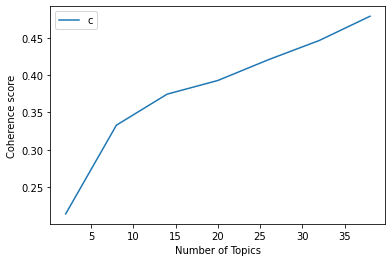

<Figure size 432x288 with 0 Axes>

In [53]:
#Model list and plot Coherence score against a number of topics
m_list, coherence_v = coherence_v_calculation(dictionary=dictionary, corpus=corpus, texts=documents, start=2, limit=40, step=6)
# Show graph

limit=40; start=2; step=6;
x = range(start, limit, step)

#Now let's plot!

plt.plot(x, coherence_v)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_v"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics- Recipe_Title.png', bbox_inches='tight',dpi = 200)

In [55]:
#For each cluster, we'll pick the top food category, eg: Salad, Pasta etc.
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=dictionary, sort_topics=False)
pyLDAvis.display(lda_display)